In [1]:
import cv2
import os
from tqdm import tqdm

In [2]:
def remove_white_borders(input_dir, output_dir):
    genres = os.listdir(input_dir)
    for genre in genres:
        genre_path = os.path.join(input_dir, genre)
        output_genre_path = os.path.join(output_dir, genre)
        os.makedirs(output_genre_path, exist_ok=True)
        images = os.listdir(genre_path)
        for img_name in tqdm(images, desc=f"Processing {genre}"):
            img_path = os.path.join(genre_path, img_name)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Warning: Unable to read {img_path}")
                continue
            # Convert to grayscale and threshold
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            _, thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)
            # Find contours
            contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            # Get bounding box of the largest contour
            if contours:
                cnt = max(contours, key=cv2.contourArea)
                x, y, w, h = cv2.boundingRect(cnt)
                # Crop and save the image
                cropped_img = img[y:y+h, x:x+w]
                output_path = os.path.join(output_genre_path, img_name)
                cv2.imwrite(output_path, cropped_img)
            else:
                # If no contour is found, save the original image
                output_path = os.path.join(output_genre_path, img_name)
                cv2.imwrite(output_path, img)

# Usage
input_directory = '../Data/images_original'
output_directory = '../Data/images_cropped'
remove_white_borders(input_directory, output_directory)

Processing classical: 100%|██████████| 100/100 [00:00<00:00, 571.01it/s]


In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [8]:
IMG_HEIGHT = 218
IMG_WIDTH = 336
BATCH_SIZE = 32

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

data_dir = '../Data/images_cropped'

train_generator = train_datagen.flow_from_directory(
    directory=data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    directory=data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 900 images belonging to 10 classes.


Found 99 images belonging to 10 classes.


In [10]:
num_classes = train_generator.num_classes

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001), input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

optimizer = RMSprop(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


model.summary()

/home/admin/MusicGenreClassifier/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
W0000 00:00:1732985686.113624 3899151 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 218, 336, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 218, 336, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 109, 168, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 109, 168, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 109, 168, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 168, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 84, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 84, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 54, 84, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 54, 84, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 27, 42, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 27, 42, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 145152)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    37,159,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,448,746 (142.86 MB)

 Trainable params: 37,448,746 (142.86 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    factor=0.5,
    min_lr=1e-6
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    restore_best_weights=True
)

callbacks = [learning_rate_reduction, early_stopping]

epochs = 200

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/30


/home/admin/MusicGenreClassifier/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


28/28 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.1247 - loss: 4.3211 - val_accuracy: 0.1042 - val_loss: 3.0598 - learning_rate: 0.0010
Epoch 2/30
 1/28 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.0938 - loss: 3.1522

/home/admin/MusicGenreClassifier/venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.0938 - loss: 3.1522 - val_accuracy: 0.1458 - val_loss: 3.0147 - learning_rate: 0.0010
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.1630 - loss: 2.9528 - val_accuracy: 0.1354 - val_loss: 2.8660 - learning_rate: 0.0010
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.0625 - loss: 2.9766 - val_accuracy: 0.1875 - val_loss: 2.8345 - learning_rate: 0.0010
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.2108 - loss: 2.7243 - val_accuracy: 0.2188 - val_loss: 2.5039 - learning_rate: 0.0010
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.3125 - loss: 2.3409 - val_accuracy: 0.2188 - val_loss: 2.4842 - learning_rate: 0.0010
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.2879 - loss: 2.4556 - val_accuracy: 0.3750 - val_loss: 2.1791 - learning_rate: 0.0010
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5938 - loss: 1.8262 - val_accuracy: 0.3542 

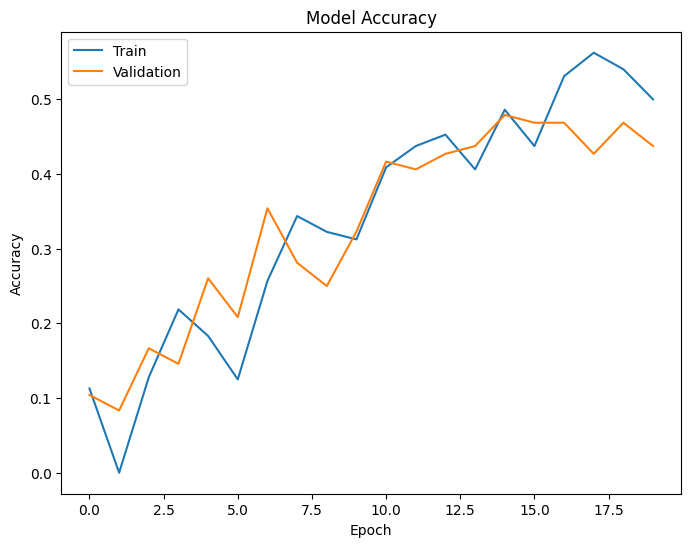

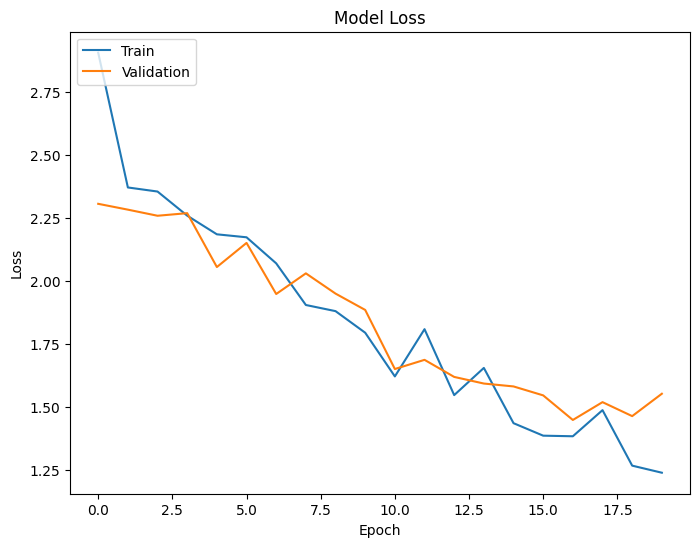

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


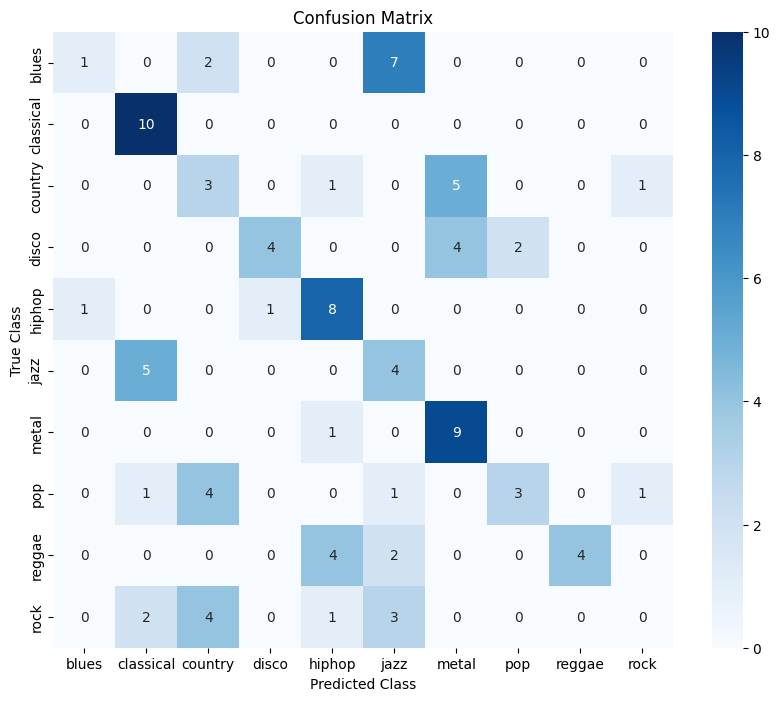

Classification Report
              precision    recall  f1-score   support

       blues       0.50      0.10      0.17        10
   classical       0.56      1.00      0.71        10
     country       0.23      0.30      0.26        10
       disco       0.80      0.40      0.53        10
      hiphop       0.53      0.80      0.64        10
        jazz       0.24      0.44      0.31         9
       metal       0.50      0.90      0.64        10
         pop       0.60      0.30      0.40        10
      reggae       1.00      0.40      0.57        10
        rock       0.00      0.00      0.00        10

    accuracy                           0.46        99
   macro avg       0.50      0.46      0.42        99
weighted avg       0.50      0.46      0.42        99



In [24]:
# Plot training & validation accuracy values
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Confusion Matrix
validation_generator.reset()
Y_pred = model.predict(validation_generator, validation_generator.samples // BATCH_SIZE + 1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_generator.classes

cm = confusion_matrix(y_true, y_pred)
class_labels = list(validation_generator.class_indices.keys())

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

# Classification Report
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=class_labels))
